In [28]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.stats import uniform
from scipy.integrate import quad

In [31]:
# "IMPLICIT" SEARCH FUNCTION

def uij(ki,gammai,Vj,t,kj):
    """Utility patient i receives from doctor j"""

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
        
def aij(u,λ):
    """Intermediate function to calculate sij"""

    return np.where(u > 0, np.exp(λ*u), 0)
                
def sij(ki,gammai,Vj,t,kj,λ):    #It takes the J-sized vectors of all doctors' Vj and κj as arguments
    """Probability that patient i visits doctor j"""

    u = uij(ki,gammai,Vj,t,kj)

    if np.sum(aij(u,λ)) == 0:
        return 0

    return aij(u,λ)/np.sum(aij(u,λ))


# Some auxiliary functions to set up chain rule derivatives

def ds_dk(ki,gammai,Vj,t,kj,λ):
    """Derivative d sij / d k"""

    u = uij(ki,gammai,Vj,t,kj)

    if np.sum(aij(u,λ)) == 0:
        return 0

    return np.divide(Vj * aij(u,λ) * np.sum(aij(u,λ)) - aij(u,λ) * np.sum(Vj * aij(u,λ)), (np.sum(aij(u,λ)))**2)


The function 'sij' gives us each patient's Si vector of strategies, and if broadcast correctly it can output all patients' strategies in a single array (given numerable patients in a MC simulation), where each column is each patient’s Si, each row could be added up to a doctor's Qi.

We keep it as a callable function for cases where we want the sij of a particular set of patient x doctor parameters, namely when calculating the derivative of our FOC.

In [4]:
class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        λ,  # Logit parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V):  # Given vector of Vj
       
        self.I, self.F, self.G, self.t, self.λ, self.R, self.P, self.V = I, F, G, t, λ, R, P, V     # Save parameters
    
    def Si(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, λ, V = self.I, self.F, self.G, self.t, self.λ, self.V    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V.reshape((-1,1))      # Reshaping doctor parameters for proper broadcasting
        kj = k0.reshape((-1,1))

        return sij(ki,gammai,Vj,t,kj,λ), ki, gammai

    def Qi_MC(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.Si(self, k0, s)

        return np.sum(S, axis = 1)
    
    def Xi_MC(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S, ki = self.Si(self, k0, s)
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def FOC_MC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Qi_MC(self, k0, s)
        X = self.Xi_MC(self, k0, s)

        return dR(Q) - dP(X)





In [30]:
# Number of doctors and patients
I = 10
J = 5

b = 5

F = expon(scale=1/b)
G = uniform
H = uniform(scale = 2)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H

r = 2
p = 1

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r
dP = lambda x: p * x

d2R = lambda x: 0
d2P = lambda x: p

df = lambda x: -b*f(x)

s_k = lambda x: sij(x,gammai,Vj,t,kj,λ)
s_kj = np.diagonal(s_k(kj.reshape(1,-1)))

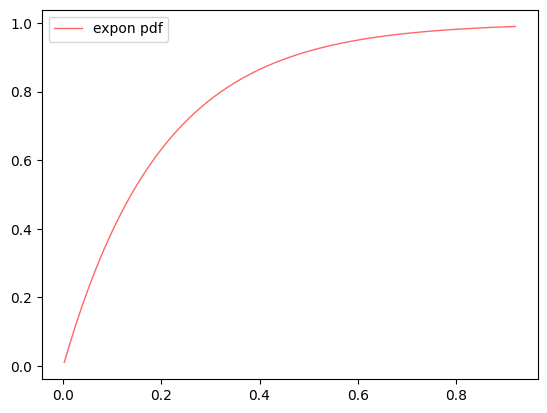

In [19]:
b = 5

# Generate x values for the plot
x = np.linspace(expon.ppf(0.01, scale=1/b), expon.ppf(0.99, scale=1/b), 100)

# Create the plot
fig, ax = plt.subplots(1, 1)
ax.plot(x, expon.cdf(x, scale=1/b), 'r-', lw=1, alpha=0.6, label='expon pdf')

# Add legend
ax.legend()

# Display the plot
plt.show()